# **Data import**

In [1]:
import numpy as np
import pandas as pd

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

X_all = train_data.drop(['SalePrice', 'Alley', 'PoolQC', 'MiscFeature'], axis=1)
y_all = train_data.SalePrice

test_data = test_data.drop(['Alley', 'PoolQC', 'MiscFeature'], axis=1)

# **Column description**

In [2]:
numeric_cols = X_all.drop(['Id', 'GarageYrBlt', 'YrSold', 'YearBuilt'], axis=1).select_dtypes(['int64', 'float64']).columns
categorial_cols = X_all.select_dtypes('object').columns.to_list()
categorial_cols.extend(['GarageYrBlt', 'YrSold', 'YearBuilt'])

# X_all = X_all.drop('YearRemodAdd', axis=1)

many_null_cols = [nc for nc in X_all.columns if len(X_all[nc][X_all[nc].isnull()]) > len(X_all.index) / 2]  # <---- for delete?
any_null_cols = [any_null_col for any_null_col in X_all.columns if X_all[any_null_col].isnull().any()]
null_to_not = ['MasVnrType', 'GarageType', 'GarageFinish', 
               'Electrical', 'FireplaceQu', 'Fence', 'BsmtQual', 
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2', 'GarageQual', 
               'GarageCond', 'GarageYrBlt']
null_to_const = ['LotFrontage', 'MasVnrArea']

any_null_cols_test = [any_null_col for any_null_col in test_data.columns if test_data[any_null_col].isnull().any()]
dif = [i for i in any_null_cols_test if i not in any_null_cols]
null_to_most_freq_test = test_data[dif].select_dtypes('object').columns.to_list()
null_to_const_test = test_data[dif].select_dtypes('float64').columns.to_list()

cols_to_order = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 
                 'FireplaceQu', 'GarageQual', 'GarageCond', 'Fence']

cols_to_onehot = [col for col in categorial_cols if col not in cols_to_order]

# **Data notes**

In [3]:
less_then_two_unique_values_cols = [i for i in X_all.columns if len(X_all[i].unique()) < 2]
#  len(less_then_two_unique_values_cols) => 0


#increased attention

useless_cols = ['Id']

suspicious_obs = list()
suspicious_obs.extend(X_all.LotFrontage[X_all.LotFrontage > 200].index.to_list()) 
# anomaly_obs in col
suspicious_obs.append(1379)
# electrical NA, only one obs.. in test without missing..delete, not, most freq, or knn


interdep_cols = [
    ['Condition1', 'Condition2'],
    ['Exterior1st', 'Exterior2nd'],
    ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 
     'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'],
    ['Fireplaces', 'FireplaceQu'], 
    ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond'], 
    ['PoolArea', 'PoolQC']
]

doubtful_cols = ['GarageYrBlt', 'YrSold', 'YearBuilt', 'YearRemodAdd'] 
#  numeric with 'not' potencially


more_then_ten_to_onehot = [i for i in cols_to_onehot if len(X_all[i].unique()) > 10]  
# len(more_then_ten_to_onehot) => 4

In [4]:
t_null_data = test_data[dif]

for i in dif:
    num = len(test_data[i][test_data[i].isnull()])
    print(f'Column: {i}. Nulls: {num}')
    print(test_data[i][test_data[i].isnull()].index.to_list(), test_data[i].dtype)
    print()
    

Column: MSZoning. Nulls: 4
[455, 756, 790, 1444] object

Column: Utilities. Nulls: 2
[455, 485] object

Column: Exterior1st. Nulls: 1
[691] object

Column: Exterior2nd. Nulls: 1
[691] object

Column: BsmtFinSF1. Nulls: 1
[660] float64

Column: BsmtFinSF2. Nulls: 1
[660] float64

Column: BsmtUnfSF. Nulls: 1
[660] float64

Column: TotalBsmtSF. Nulls: 1
[660] float64

Column: BsmtFullBath. Nulls: 2
[660, 728] float64

Column: BsmtHalfBath. Nulls: 2
[660, 728] float64

Column: KitchenQual. Nulls: 1
[95] object

Column: Functional. Nulls: 2
[756, 1013] object

Column: GarageCars. Nulls: 1
[1116] float64

Column: GarageArea. Nulls: 1
[1116] float64

Column: SaleType. Nulls: 1
[1029] object



# **Data optimization. Part 1**

In [5]:
X_all = X_all.drop('Id', axis=1)
test_id = test_data['Id']
test_data = test_data.drop('Id', axis=1)

electrical_null_idx = X_all['Electrical'][X_all['Electrical'].isnull()].index
X_all.loc[electrical_null_idx, 'Electrical'] = X_all['Electrical'].value_counts().index[0]


# **Missing value recovery**

In [6]:
from sklearn.impute import SimpleImputer

X = X_all.copy()
X_test = test_data.copy()

X[null_to_not] = X[null_to_not].fillna('not')
X_test[null_to_not] = X_test[null_to_not].fillna('not')

X[null_to_const] = X[null_to_const].fillna(0)
X_test[null_to_const] = X_test[null_to_const].fillna(0)
X_test[null_to_const_test] = X_test[null_to_const_test].fillna(0)

imp = SimpleImputer(strategy='most_frequent')

X_test[null_to_most_freq_test] = pd.DataFrame(imp.fit_transform(X_test[null_to_most_freq_test]))
X_test[null_to_most_freq_test].columns = null_to_most_freq_test


# **Сategorical transformation**

In [7]:
from sklearn.preprocessing import OrdinalEncoder

categories_to_order = [
    ['not', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['not', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], 
    ['not', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['not', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['not', 'No', 'Mn', 'Av', 'Gd'], ['not', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['not', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ['not', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['not', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['not', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], 
    ['not', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['not', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], 
    ['not', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
]

ord_enc = OrdinalEncoder(categories=categories_to_order)
X[cols_to_order] = ord_enc.fit_transform(X[cols_to_order])
X_test[cols_to_order] = ord_enc.transform(X_test[cols_to_order])

X_onehot = pd.get_dummies(X[cols_to_onehot])
X_test_onehot = pd.get_dummies(X_test[cols_to_onehot])

X = X.drop(cols_to_onehot, axis = 1)
X_test = X_test.drop(cols_to_onehot, axis = 1)

X = pd.concat([X, X_onehot], axis=1)
X_test = pd.concat([X_test, X_test_onehot], axis=1)

# **Data optimization. Part 2**

In [8]:
# from sklearn.ensemble import IsolationForest

# model_IF = IsolationForest(contamination=0.01, random_state=42)
# model_IF.fit(X[numeric_cols])

# X_new = pd.DataFrame()
# X_new['anomaly_scores'] = model_IF.decision_function(X[numeric_cols])
# X_new['anomaly'] = model_IF.predict(X[numeric_cols])

# anomaly_idxs = X_new['anomaly'][X_new['anomaly'] < 0].index
# anomaly_idxs
# # X_new = X.drop(anomaly_idxs)
# # y_all_new = y_all.drop(anomaly_idxs)

In [9]:
conda install -c conda-forge xgboost

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\anaconda3

  added / updated specs:
    - xgboost


The following NEW packages will be INSTALLED:

  _py-xgboost-mutex  conda-forge/win-64::_py-xgboost-mutex-2.0-gpu_0 
  libxgboost         pkgs/main/win-64::libxgboost-2.0.3-h5da7b33_0 
  py-xgboost         conda-forge/noarch::py-xgboost-2.0.3-cuda120_pyh3ef1b53_4 
  xgboost            conda-forge/noarch::xgboost-2.0.3-cuda120_pyh68bd8d9_4 

The following packages will be UPDATED:

  ca-certificates    pkgs/main::ca-certificates-2023.01.10~ --> conda-forge::ca-certificates-2024.6.2-h56e8100_0 
  certifi            pkgs/main/win-64::certifi-2022.12.7-p~ --> conda-forge/noarch::certifi-2024.6.2-pyhd8ed1ab_0 
  openssl                                 1.1.1t-h2bbff1b_0 --> 1.1.1w-h2bbff1b_0 





Preparing transaction: ...working... done
Verifying transaction: ...working... failed

Note: you may need to restart the kernel to use updated pack



==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0



EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: C:\ProgramData\anaconda3




# **Model optimization**

In [11]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error

pre_model = XGBRegressor(
    n_estimators=460, 
    learning_rate=0.05, 
    random_state=42, 
    n_jobs=-1,
    reg_alpha=1.3,
    reg_lambda=8
)

In [64]:
# from sklearn.model_selection import GridSearchCV

# params = {
#     'n_estimators': range(459, 462),
#     'learning_rate': [0.049, 0.05, 0.051], 
#     'reg_alpha': [a / 10 for a in range(5, 15)] + [0], 
#     'reg_lambda': [a / 10 for a in range(75, 85)] + [0]   
# }

# grid = GridSearchCV(
#     pre_model, 
#     params, 
#     n_jobs=-1, 
#     scoring='neg_mean_squared_log_error', 
#     cv=5,
#     verbose=2
# )

# grid.fit(X, y_all)

In [65]:
# print(grid.best_params_)

In [12]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pre_model, X, y_all, cv=5, scoring='neg_mean_squared_log_error')
scores.mean() * -1


0.01665420184641304

<BarContainer object of 50 artists>

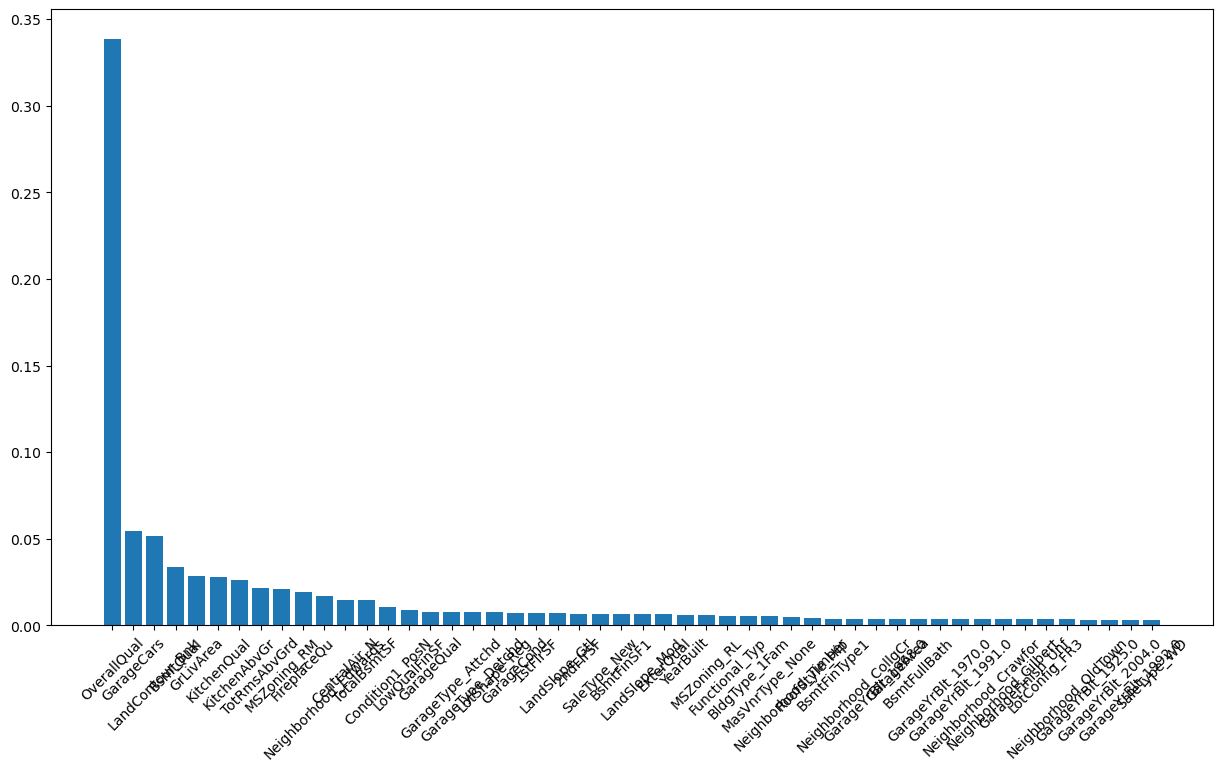

In [18]:
import matplotlib.pyplot as plt

pre_model.fit(X, y_all)

feat_imp = pre_model.feature_importances_
feat_names = pre_model.feature_names_in_

df_imp = pd.DataFrame(index=feat_names, data=feat_imp).sort_values(0, ascending=False)

plt.figure(figsize=(15, 8))
plt.xticks(rotation=45)
plt.bar(df_imp.index[0:50], df_imp[0][0:50])

In [21]:
not_used_features = df_imp[df_imp[0] == 0].index
most_important_feature = df_imp.index[0]

df_imp.sort_values(0, ascending=False).head(10)

,0
OverallQual,0.338814
GarageCars,0.054379
LandContour_Bnk,0.051692
BsmtQual,0.033604
GrLivArea,0.028485
KitchenQual,0.028104
KitchenAbvGr,0.026327
TotRmsAbvGrd,0.021370
MSZoning_RM,0.020779
FireplaceQu,0.019305


# **Experimental block**

In [72]:
# from sklearn.model_selection import train_test_split

# pre_model.fit(X, y_all)

# folds_list = list()
# for s in range(5, 10):
#     part = s / 10
#     X_t, X_v, y_t, y_v = train_test_split(X, y_all, random_state=42, train_size = part)
#     pre_model.fit(X_t, y_t)
#     pred = pre_model.predict(X_v)
#     score = mean_squared_log_error(y_v, pred)
#     folds_list.append([part, score])
    
    
# import matplotlib.pyplot as plt

# folds = [i[0] for i in folds_list]
# scores = [i[1] for i in folds_list]

# plt.plot(folds, scores)

# **Final prediction**

In [22]:
X, X_test = X.align(X_test, join='left', axis=1)

model = XGBRegressor(
    n_estimators=460,
    learning_rate=0.05,
    reg_alpha=1.3,
    reg_lambda=8
)

model.fit(X, y_all)

predictions = model.predict(X_test)

In [23]:
output = pd.DataFrame({'Id': test_id,
                       'SalePrice': predictions})
output.to_csv('submission.csv', index=False)